# F1 Tire Strategy with MULTIYEAR Model (2022 + 2023)

## Key Improvements:
- ✅ Uses 2022 + 2023 data (~47,000 laps)
- ✅ Proper temporal validation (train on 2022, test on 2023)
- ✅ Better generalization
- ✅ Strategy simulation for Bahrain GP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

print("✅ Imports complete!")

✅ Imports complete!


## 1. Load Multi-Year Data (2022 + 2023)

In [2]:
# Load 2023 data
print("Loading 2023 data...")
df_2023 = pd.read_csv('data/f1_ml_laps_dataset.csv')
df_2023['season'] = 2023

# Load 2022 data
print("Loading 2022 data...")
df_2022 = pd.read_csv('data/f1_2022_races.csv')
df_2022['season'] = df_2022['season'].fillna(2022).astype(int)

# Combine both years
df = pd.concat([df_2022, df_2023], ignore_index=True)
df = df.sort_values(['season', 'gp_name', 'driver', 'lap_number']).reset_index(drop=True)
df['lap_time'] = df['lap_time'].astype(float)

print("="*70)
print("MULTI-YEAR F1 DATA (2022 + 2023)")
print("="*70)
print(f"Total laps: {len(df):,}")
print(f"\nLaps per season:")
print(df['season'].value_counts().sort_index())
print(f"\nTotal tracks: {df['gp_name'].nunique()}")
print(f"Total drivers: {df['driver'].nunique()}")
print("="*70)

Loading 2023 data...
Loading 2022 data...
MULTI-YEAR F1 DATA (2022 + 2023)
Total laps: 47,033

Laps per season:
season
2022    23050
2023    23983
Name: count, dtype: int64

Total tracks: 24
Total drivers: 25


## 2. Feature Engineering

In [3]:
group = ['gp_name', 'driver']

# Lag features
df["prev_lap_time"]  = df.groupby(group)["lap_time"].shift(1)
df["prev2_lap_time"] = df.groupby(group)["lap_time"].shift(2)
df["prev3_lap_time"] = df.groupby(group)["lap_time"].shift(3)

# Rolling features
df["rolling_mean_3"] = df.groupby(group)["lap_time"].transform(lambda x: x.rolling(3, min_periods=1).mean())
df["rolling_mean_5"] = df.groupby(group)["lap_time"].transform(lambda x: x.rolling(5, min_periods=1).mean())
df["rolling_std_3"]  = df.groupby(group)["lap_time"].transform(lambda x: x.rolling(3, min_periods=1).std())

# Tire features
df['lap_time_change'] = df.groupby(group)['lap_time'].diff()
df['tyre_life_sq'] = df['tyre_life'] ** 2

# Weather changes
for col in ['air_temp','track_temp','humidity','wind_speed','pressure','wind_dir']:
    if col in df.columns:
        df[f"{col}_change"] = df.groupby(group)[col].transform(lambda x: x.diff())

# Original next-lap target (still keep this for cleaning)
df["target_next_lap"] = df.groupby(group)["lap_time"].shift(-1)

# ============================================================
#                CHANGE 2 — IMPROVED TARGET
#  Replace target_next_lap with lap_time - rolling_mean_5
# ============================================================
df["target_next_lap"] = df["lap_time"] - df["rolling_mean_5"]

print("✅ Features + Improved target created!")

✅ Features + Improved target created!


In [4]:
# group = ['gp_name', 'driver']

# # Lag features
# df["prev_lap_time"]  = df.groupby(group)["lap_time"].shift(1)
# df["prev2_lap_time"] = df.groupby(group)["lap_time"].shift(2)
# df["prev3_lap_time"] = df.groupby(group)["lap_time"].shift(3)

# # Rolling features
# df["rolling_mean_3"] = df.groupby(group)["lap_time"].transform(lambda x: x.rolling(3, min_periods=1).mean())
# df["rolling_mean_5"] = df.groupby(group)["lap_time"].transform(lambda x: x.rolling(5, min_periods=1).mean())
# df["rolling_std_3"]  = df.groupby(group)["lap_time"].transform(lambda x: x.rolling(3, min_periods=1).std())

# # Tire features
# df['lap_time_change'] = df.groupby(group)['lap_time'].diff()
# df['tyre_life_sq'] = df['tyre_life'] ** 2

# # Weather changes
# for col in ['air_temp','track_temp','humidity','wind_speed','pressure','wind_dir']:
#     if col in df.columns:
#         df[f"{col}_change"] = df.groupby(group)[col].transform(lambda x: x.diff())

# # Target (next lap time)
# df["target_next_lap"] = df.groupby(group)["lap_time"].shift(-1)

# print("✅ Features created!")

## 3. Prepare Training Data

In [5]:
# ============================================================
# CLEAN DATASET
# ============================================================
df_model = df.dropna(subset=[
    "target_next_lap","prev_lap_time","prev2_lap_time","prev3_lap_time"
]).copy()

print(f"Clean dataset: {len(df_model):,} laps")


# ============================================================
# ADD NEW FEATURES (CHANGE 1)
# ============================================================

# Ensure season is numeric
df_model["season"] = df_model["season"].astype(int)

# Track identity features
df_model["track_name"] = df_model["gp_name"]
df_model["track_id"] = df_model["gp_name"].astype("category").cat.codes

# ---- TRACK STATIC METADATA ----
track_meta = {
    # --- Middle East / Opening ---
    "Bahrain Grand Prix":                    {"track_length": 5.412, "num_corners": 15, "longest_straight": 1090, "abrasion": 3},
    "Saudi Arabian Grand Prix":              {"track_length": 6.174, "num_corners": 27, "longest_straight": 1200, "abrasion": 1},

    # --- Australia / Asia ---
    "Australian Grand Prix":                 {"track_length": 5.278, "num_corners": 14, "longest_straight": 870,  "abrasion": 2},
    "Azerbaijan Grand Prix":                 {"track_length": 6.003, "num_corners": 20, "longest_straight": 2000, "abrasion": 1},
    "Miami Grand Prix":                      {"track_length": 5.412, "num_corners": 19, "longest_straight": 1400, "abrasion": 2},

    # --- Europe ---
    "Emilia Romagna Grand Prix":             {"track_length": 4.909, "num_corners": 19, "longest_straight": 970,  "abrasion": 2},
    "Monaco Grand Prix":                     {"track_length": 3.337, "num_corners": 19, "longest_straight": 510,  "abrasion": 1},
    "Spanish Grand Prix":                    {"track_length": 4.675, "num_corners": 14, "longest_straight": 1047, "abrasion": 3},
    "Canadian Grand Prix":                   {"track_length": 4.361, "num_corners": 14, "longest_straight": 1064, "abrasion": 2},
    "Austrian Grand Prix":                   {"track_length": 4.318, "num_corners": 10, "longest_straight": 939,  "abrasion": 2},
    "British Grand Prix":                    {"track_length": 5.891, "num_corners": 18, "longest_straight": 770,  "abrasion": 3},
    "Hungarian Grand Prix":                  {"track_length": 4.381, "num_corners": 14, "longest_straight": 800,  "abrasion": 2},
    "Belgian Grand Prix":                    {"track_length": 7.004, "num_corners": 19, "longest_straight": 750,  "abrasion": 2},
    "Dutch Grand Prix":                      {"track_length": 4.259, "num_corners": 14, "longest_straight": 670,  "abrasion": 3},
    "Italian Grand Prix":                    {"track_length": 5.793, "num_corners": 11, "longest_straight": 1120, "abrasion": 1},

    # --- Asia / Americas ---
    "Singapore Grand Prix":                  {"track_length": 4.940, "num_corners": 19, "longest_straight": 830,  "abrasion": 1},
    "Japanese Grand Prix":                   {"track_length": 5.807, "num_corners": 18, "longest_straight": 1300, "abrasion": 2},
    "United States Grand Prix":              {"track_length": 5.513, "num_corners": 20, "longest_straight": 1200, "abrasion": 2},
    "Mexico City Grand Prix":                {"track_length": 4.304, "num_corners": 17, "longest_straight": 1200, "abrasion": 3},
    "São Paulo Grand Prix":                  {"track_length": 4.309, "num_corners": 15, "longest_straight": 650,  "abrasion": 3},

    # --- Special / New Tracks ---
    "Las Vegas Grand Prix":                  {"track_length": 6.201, "num_corners": 17, "longest_straight": 1938, "abrasion": 1},
    "Qatar Grand Prix":                      {"track_length": 5.380, "num_corners": 16, "longest_straight": 1068, "abrasion": 2},
    "Abu Dhabi Grand Prix":                  {"track_length": 5.281, "num_corners": 16, "longest_straight": 1200, "abrasion": 2},

    # --- Removed / Only 2022 ---
    "French Grand Prix":                     {"track_length": 5.842, "num_corners": 15, "longest_straight": 1800, "abrasion": 2},
}


df_model["track_length"]      = df_model["gp_name"].map(lambda x: track_meta.get(x, {}).get("track_length", 5.0))
df_model["num_corners"]       = df_model["gp_name"].map(lambda x: track_meta.get(x, {}).get("num_corners", 15))
df_model["longest_straight"]  = df_model["gp_name"].map(lambda x: track_meta.get(x, {}).get("longest_straight", 800))
df_model["abrasion"]          = df_model["gp_name"].map(lambda x: track_meta.get(x, {}).get("abrasion", 2))


# ============================================================
# FEATURE DEFINITIONS (YOUR ORIGINAL BLOCK + CHANGES)
# ============================================================

# Numeric features (keep your original list)
numeric_features = [c for c in [
    'lap_number',
    'prev_lap_time','prev2_lap_time','prev3_lap_time',
    'rolling_mean_3','rolling_mean_5','rolling_std_3',
    'tyre_life','tyre_life_sq','stint','fresh_tyre',
    'lap_time_change',
    'is_pit_lap','position',
    'air_temp','track_temp','humidity','wind_speed','pressure','wind_dir'
] if c in df_model.columns]

numeric_features += [
    c for c in df_model.columns 
    if c.endswith('_change') and c != 'lap_time_change'
]

# ----- ADD NEW NUMERIC TRACK FEATURES -----
numeric_features += [
    "track_length", "num_corners", "longest_straight", "abrasion",
    "season"   # treat season as numeric continuous feature
]


# Categorical features (your originals + NEW ONES)
categorical_features = [
    c for c in ['driver','team','compound','gp_name'] if c in df_model.columns
]

# ----- ADD NEW CATEGORICAL TRACK FEATURES -----
categorical_features += ["track_name"]


# FINAL FEATURE LIST
feature_cols = numeric_features + categorical_features

print(f"Features: {len(numeric_features)} numeric + {len(categorical_features)} categorical")
print("\n✅ Added: season, track_name, track physics metadata")


Clean dataset: 45,393 laps
Features: 31 numeric + 5 categorical

✅ Added: season, track_name, track physics metadata


In [6]:
# # Clean dataset
# df_model = df.dropna(subset=[
#     "target_next_lap","prev_lap_time","prev2_lap_time","prev3_lap_time"
# ]).copy()

# print(f"Clean dataset: {len(df_model):,} laps")

# # Define features (EXCLUDE track_status for strategy)
# numeric_features = [c for c in [
#     'lap_number',
#     'prev_lap_time','prev2_lap_time','prev3_lap_time',
#     'rolling_mean_3','rolling_mean_5','rolling_std_3',
#     'tyre_life','tyre_life_sq','stint','fresh_tyre',
#     'lap_time_change',
#     'is_pit_lap','position',
#     'air_temp','track_temp','humidity','wind_speed','pressure','wind_dir'
# ] if c in df_model.columns]

# numeric_features += [c for c in df_model.columns if c.endswith('_change') and c != 'lap_time_change']

# # Categorical features (NO track_status for strategy!)
# categorical_features = [c for c in ['driver','team','compound','gp_name'] 
#                         if c in df_model.columns]

# feature_cols = numeric_features + categorical_features

# print(f"Features: {len(numeric_features)} numeric + {len(categorical_features)} categorical")
# print(f"\n✅ Excluded track_status (not useful for strategy planning)")

## 4. Temporal Train/Test Split (2022 → 2023)

In [7]:
holdout_gp = "Bahrain Grand Prix"
train_mask = ~(
    (df_model["season"] == 2023) &
    (df_model["gp_name"] == holdout_gp)
)

test_mask = (
    (df_model["season"] == 2023) &
    (df_model["gp_name"] == holdout_gp)
)
train_df = df_model[train_mask].copy()
test_df  = df_model[test_mask].copy()

X_train_raw = train_df[feature_cols]
X_test_raw  = test_df[feature_cols]

y_train = train_df["target_next_lap"]
y_test  = test_df["target_next_lap"]

# One-hot encode
X_train = pd.get_dummies(X_train_raw, columns=categorical_features, drop_first=True)
X_test  = pd.get_dummies(X_test_raw, columns=categorical_features, drop_first=True)

# Align columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print("="*70)
print("TEMPORAL VALIDATION: HOLD-OUT = 2023 Bahrain GP")
print("="*70)
print(f"Training rows: {len(X_train):,}")
print(f"Test rows:     {len(X_test):,}")
print(f"Train/Test ratio: {len(X_train)/len(X_test):.1f}x")
print("✓ 2022 fully included")
print("✓ 2023 except Bahrain included")
print("✓ No leakage")
print("="*70)


TEMPORAL VALIDATION: HOLD-OUT = 2023 Bahrain GP
Training rows: 44,347
Test rows:     1,046
Train/Test ratio: 42.4x
✓ 2022 fully included
✓ 2023 except Bahrain included
✓ No leakage


## 5. Train Model

In [8]:
print("="*70)
print("TRAINING LAP TIME PREDICTION MODEL")
print("="*70)
from xgboost import XGBRegressor
model = XGBRegressor(
        n_estimators=300, max_depth=8, learning_rate=0.05, 
        subsample=0.9, random_state=42, verbosity=0
    )

print("Training XGBRegressor on data...")
model.fit(X_train, y_train)
print("✅ Training complete!")

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metrics
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\n" + "="*70)
print("MODEL PERFORMANCE")
print("="*70)
print(f"\nTRAINING :")
print(f"  R²   : {train_r2:.6f}")
print(f"  MAE  : {train_mae:.4f}s")
print(f"  RMSE : {train_rmse:.4f}s")

print(f"\nTEST (2023 - HOLD-OUT RACE):")
print(f"  R²   : {test_r2:.6f}")
print(f"  MAE  : {test_mae:.4f}s")
print(f"  RMSE : {test_rmse:.4f}s")

r2_drop = train_r2 - test_r2
print(f"\nOVERFITTING CHECK:")
print(f"  R² drop (train→test): {r2_drop:.4f}")
if r2_drop < 0.15:
    print(f"  ✅ Excellent generalization!")
elif r2_drop < 0.25:
    print(f"  ✅ Good generalization")
else:
    print(f"  ⚠️  Some overfitting (expected with year-to-year changes)")

print("="*70)

TRAINING LAP TIME PREDICTION MODEL
Training XGBRegressor on data...
✅ Training complete!

MODEL PERFORMANCE

TRAINING :
  R²   : 0.998487
  MAE  : 0.1903s
  RMSE : 0.2815s

TEST (2023 - HOLD-OUT RACE):
  R²   : 0.984583
  MAE  : 0.3407s
  RMSE : 0.6940s

OVERFITTING CHECK:
  R² drop (train→test): 0.0139
  ✅ Excellent generalization!


## 6. Visualize Model Performance

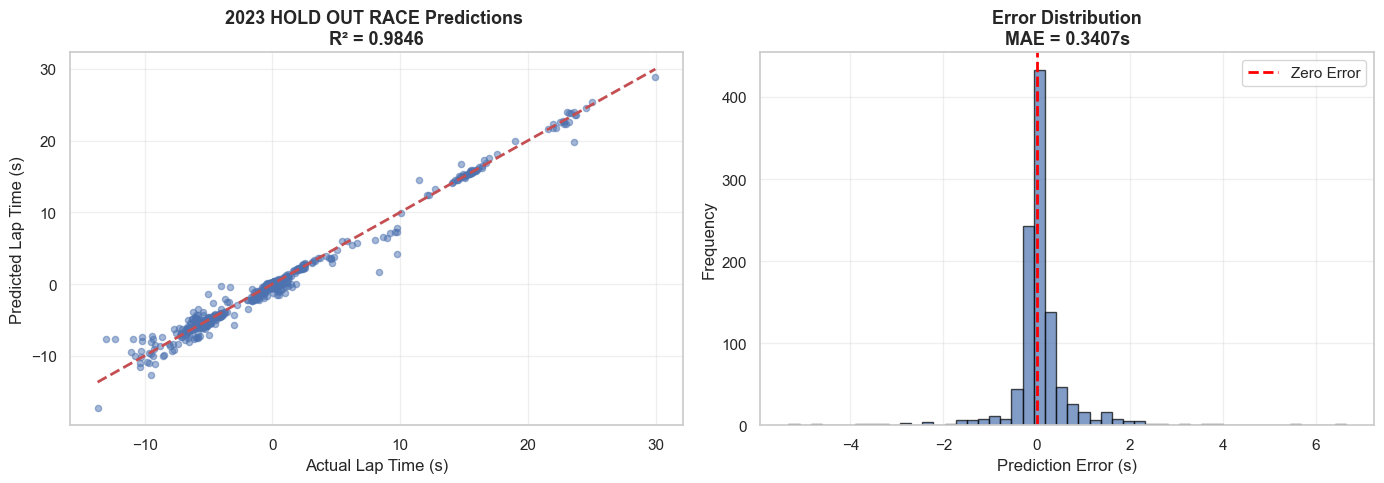

✅ Saved: tire_strategy_multiyear_performance.png


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_test, y_test_pred, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Lap Time (s)', fontsize=12)
axes[0].set_ylabel('Predicted Lap Time (s)', fontsize=12)
axes[0].set_title(f'2023 HOLD OUT RACE Predictions \nR² = {test_r2:.4f}', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_test_pred
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Prediction Error (s)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'Error Distribution\nMAE = {test_mae:.4f}s', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tire_strategy_multiyear_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: tire_strategy_multiyear_performance.png")

## 7. Feature Importance

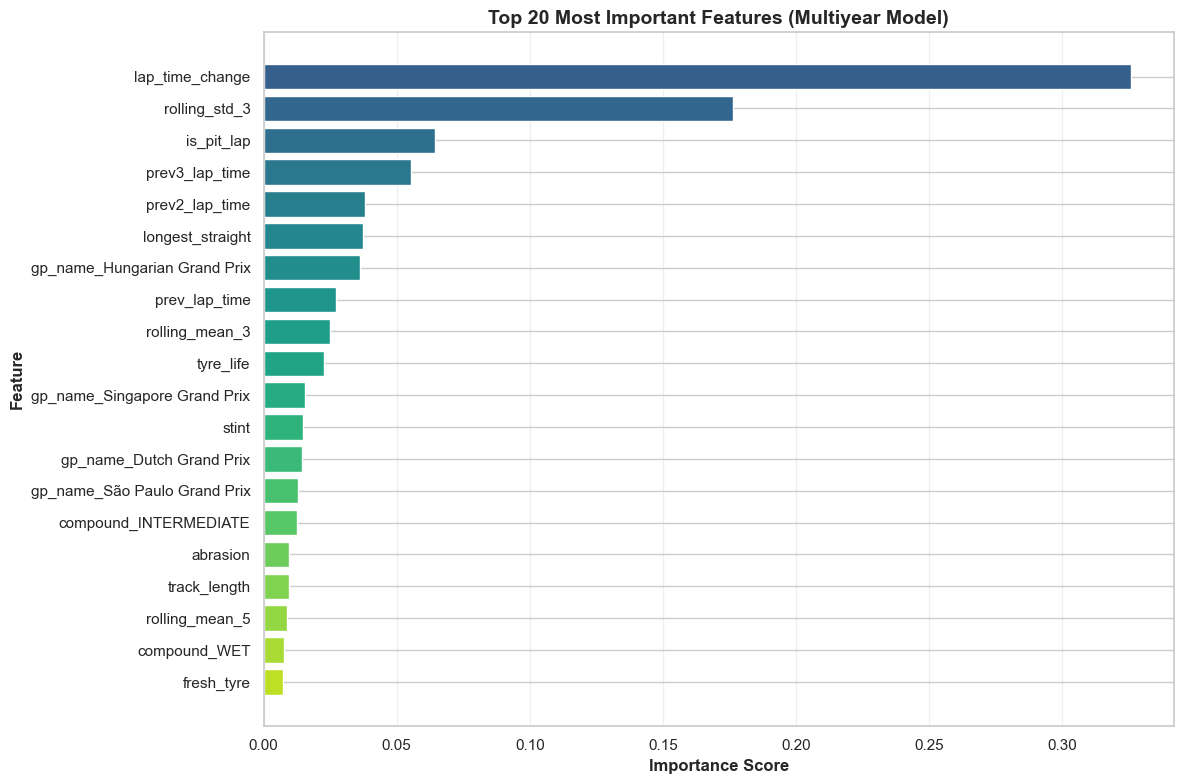


📊 Top 10 Features:
   lap_time_change                0.3256
   rolling_std_3                  0.1764
   is_pit_lap                     0.0645
   prev3_lap_time                 0.0554
   prev2_lap_time                 0.0382
   longest_straight               0.0372
   gp_name_Hungarian Grand Prix   0.0361
   prev_lap_time                  0.0273
   rolling_mean_3                 0.0250
   tyre_life                      0.0226

✅ Saved: tire_strategy_multiyear_features.png


In [16]:
# Get feature importances
importances = model.feature_importances_
feat_imp_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values('importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feat_imp_df)))
plt.barh(range(len(feat_imp_df)), feat_imp_df['importance'], color=colors)
plt.yticks(range(len(feat_imp_df)), feat_imp_df['feature'])
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Top 20 Most Important Features (Multiyear Model)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('tire_strategy_multiyear_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Top 10 Features:")
for idx, row in feat_imp_df.head(10).iterrows():
    print(f"   {row['feature']:30s} {row['importance']:.4f}")
    
print("\n✅ Saved: tire_strategy_multiyear_features.png")

## 8. Strategy Simulation for Bahrain GP

Now we'll use this trained model to simulate tire strategies.

In [17]:
# Get typical Bahrain conditions from 2023 data
bahrain_2023 = df_model[(df_model['gp_name'] == 'Bahrain Grand Prix') & (df_model['season'] == 2023)]

if len(bahrain_2023) > 0:
    weather_bahrain = {
        'track_temp': bahrain_2023['track_temp'].mean(),
        'air_temp': bahrain_2023['air_temp'].mean(),
        'humidity': bahrain_2023['humidity'].mean(),
        'wind_speed': bahrain_2023['wind_speed'].mean(),
        'wind_dir': bahrain_2023['wind_dir'].mean(),
        'pressure': bahrain_2023['pressure'].mean()
    }
else:
    # Use typical values
    weather_bahrain = {
        'track_temp': 36.0,
        'air_temp': 28.0,
        'humidity': 40.0,
        'wind_speed': 3.2,
        'wind_dir': 140.0,
        'pressure': 1006.0
    }

print("="*70)
print("BAHRAIN GP CONDITIONS")
print("="*70)
for k, v in weather_bahrain.items():
    print(f"  {k:15s}: {v:.2f}")
print("="*70)

BAHRAIN GP CONDITIONS
  track_temp     : 29.89
  air_temp       : 26.74
  humidity       : 21.09
  wind_speed     : 0.50
  wind_dir       : 176.46
  pressure       : 1017.02


In [48]:
def predict_lap_time_simple(compound, tyre_life, stint, lap_number, weather, gp_name='Bahrain Grand Prix'):
    """
    Simplified lap time prediction for strategy simulation.
    Uses average values for rolling features.
    """
    # Create base features
    row = {
        'lap_number': lap_number,
        'tyre_life': tyre_life,
        'tyre_life_sq': tyre_life ** 2,
        'stint': stint,
        'fresh_tyre': 1 if tyre_life == 1 else 0,
        'is_pit_lap': 0,
        'position': 5,
        'track_temp': weather['track_temp'],
        'air_temp': weather['air_temp'],
        'humidity': weather['humidity'],
        'wind_speed': weather['wind_speed'],
        'wind_dir': weather['wind_dir'],
        'pressure': weather['pressure'],
        # Use realistic averages for rolling features
        'prev_lap_time': 95.0,
        'prev2_lap_time': 95.0,
        'prev3_lap_time': 95.0,
        'rolling_mean_3': 95.0,
        'rolling_mean_5': 95.0,
        'rolling_std_3': 0.5,
        'lap_time_change': 0.1,
    }
    
    # Add weather change features (set to 0)
    for col in ['air_temp_change', 'track_temp_change', 'humidity_change',
                'wind_speed_change', 'pressure_change', 'wind_dir_change']:
        row[col] = 0.0
    
    # Create DataFrame
    row_df = pd.DataFrame([row])
    
    # Add categorical features
    row_df['compound'] = compound
    row_df['gp_name'] = gp_name
    row_df['driver'] = 'VER'  # Default
    row_df['team'] = 'Red Bull Racing'
    row_df['track_name'] = gp_name
    
    # One-hot encode
    row_encoded = pd.get_dummies(row_df, columns=categorical_features, drop_first=True)
    row_encoded = row_encoded.reindex(columns=X_train.columns, fill_value=0)
    
    BASE_LAP = {
    'SOFT': 90.2,
    'MEDIUM': 91.0,
    'HARD': 92.0
    }

    # return float(model.predict(row_encoded)[0])
    delta = float(model.predict(row_encoded)[0])
    base = BASE_LAP[compound]
    return base + delta


print("✅ Prediction function defined")

✅ Prediction function defined


In [49]:
def simulate_race_strategy(strategy, total_laps, pit_loss, weather, gp_name='Bahrain Grand Prix'):
    """
    Simulate tire strategy.
    
    Args:
        strategy: [(compound, stint_length), ...]
        total_laps: Total race laps
        pit_loss: Pit stop time penalty
        weather: Weather dict
    """
    total_time = 0.0
    lap_num = 1
    stint_idx = 0
    laps = []
    
    for compound, stint_len in strategy:
        stint_idx += 1
        
        for tyre_life in range(1, stint_len + 1):
            if lap_num > total_laps:
                break
            
            lap_time = predict_lap_time_simple(
                compound, tyre_life, stint_idx, lap_num, weather, gp_name
            )
            
            total_time += lap_time
            laps.append({
                'lap': lap_num,
                'compound': compound,
                'tyre_life': tyre_life,
                'lap_time': lap_time
            })
            lap_num += 1
        
        # Pit stop (except after last stint)
        if lap_num <= total_laps:
            total_time += pit_loss
    
    return total_time, pd.DataFrame(laps)

print("✅ Strategy simulator defined")

✅ Strategy simulator defined


## 9. Find Optimal Strategy for Bahrain

In [50]:
total_laps = 57
pit_loss = 20.0
compounds = ['SOFT', 'MEDIUM', 'HARD']

print("="*70)
print("SEARCHING FOR OPTIMAL TIRE STRATEGY - BAHRAIN GP")
print("="*70)
print(f"Total laps: {total_laps}")
print(f"Pit stop time: {pit_loss}s")
print("\nTesting 1-stop strategies...\n")

results = []

for c1 in compounds:
    for c2 in compounds:
        if c1 == c2:
            continue
        
        for pit_lap in range(20, 38, 2):
            s1 = pit_lap
            s2 = total_laps - s1
            
            if s2 < 15 or s2 > 40:
                continue
            
            strategy = [(c1, s1), (c2, s2)]
            
            total_time, _ = simulate_race_strategy(
                strategy, total_laps, pit_loss, weather_bahrain
            )
            
            results.append({
                'strategy': f"{c1}({s1}) → {c2}({s2})",
                'pit_lap': pit_lap,
                'total_time': total_time
            })

results_df = pd.DataFrame(results).sort_values('total_time')

print("🏆 TOP 10 STRATEGIES:")
print("="*70)
print(results_df.head(10).to_string(index=False))
print("="*70)

SEARCHING FOR OPTIMAL TIRE STRATEGY - BAHRAIN GP
Total laps: 57
Pit stop time: 20.0s

Testing 1-stop strategies...

🏆 TOP 10 STRATEGIES:
             strategy  pit_lap  total_time
MEDIUM(20) → SOFT(37)       20 5123.018984
SOFT(36) → MEDIUM(21)       36 5123.965360
MEDIUM(22) → SOFT(35)       22 5124.653899
SOFT(34) → MEDIUM(23)       34 5125.562033
MEDIUM(24) → SOFT(33)       24 5126.288659
SOFT(32) → MEDIUM(25)       32 5127.158706
MEDIUM(26) → SOFT(31)       26 5127.920355
SOFT(30) → MEDIUM(27)       30 5128.755379
MEDIUM(28) → SOFT(29)       28 5129.552051
SOFT(28) → MEDIUM(29)       28 5130.352051


## 10. Visualize Best Strategy


🏆 OPTIMAL STRATEGY: MEDIUM(20) → SOFT(37)
   Pit lap: 20
   Total time: 5123.02s


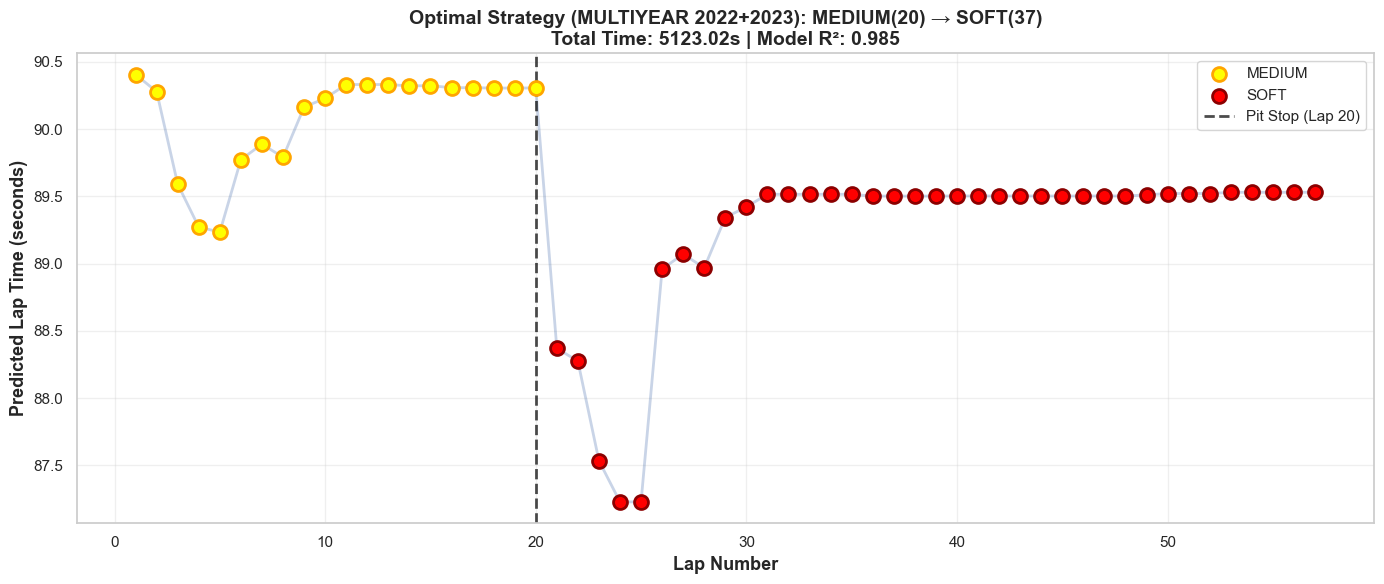


✅ Saved: tire_strategy_multiyear_optimal.png


In [51]:
# Get best strategy
best = results_df.iloc[0]
print(f"\n🏆 OPTIMAL STRATEGY: {best['strategy']}")
print(f"   Pit lap: {best['pit_lap']}")
print(f"   Total time: {best['total_time']:.2f}s")

# Extract components
import re
match = re.match(r"(\w+)\((\d+)\) → (\w+)\((\d+)\)", best['strategy'])
c1, s1, c2, s2 = match.groups()
best_strategy = [(c1, int(s1)), (c2, int(s2))]

# Simulate
_, lap_details = simulate_race_strategy(
    best_strategy, total_laps, pit_loss, weather_bahrain
)

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

colors = {'SOFT': 'red', 'MEDIUM': 'yellow', 'HARD': 'white'}
edge_colors = {'SOFT': 'darkred', 'MEDIUM': 'orange', 'HARD': 'black'}

for compound in lap_details['compound'].unique():
    data = lap_details[lap_details['compound'] == compound]
    ax.scatter(data['lap'], data['lap_time'], 
              c=colors[compound], edgecolors=edge_colors[compound],
              s=100, label=compound, linewidth=2, zorder=3)

ax.plot(lap_details['lap'], lap_details['lap_time'], 
        'b-', alpha=0.3, linewidth=2, zorder=1)

ax.axvline(int(s1), color='black', linestyle='--', linewidth=2, 
          label=f'Pit Stop (Lap {s1})', alpha=0.7)

ax.set_xlabel('Lap Number', fontsize=13, fontweight='bold')
ax.set_ylabel('Predicted Lap Time (seconds)', fontsize=13, fontweight='bold')
ax.set_title(f'Optimal Strategy (MULTIYEAR 2022+2023): {best["strategy"]}\n' +
            f'Total Time: {best["total_time"]:.2f}s | Model R²: {test_r2:.3f}', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('tire_strategy_multiyear_optimal.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: tire_strategy_multiyear_optimal.png")

## 11. Final Summary

In [52]:
print("="*70)
print("TIRE STRATEGY WITH MULTIYEAR MODEL - FINAL SUMMARY")
print("="*70)

print("\n📊 MODEL PERFORMANCE:")
print(f"   Training R² (2022):  {train_r2:.6f}")
print(f"   Test R² (2023):      {test_r2:.6f}")
print(f"   Test MAE:            {test_mae:.4f}s")
print(f"   R² drop:             {r2_drop:.4f}")

print("\n🏆 OPTIMAL BAHRAIN STRATEGY:")
print(f"   {best['strategy']}")
print(f"   Pit on lap: {best['pit_lap']}")
print(f"   Total time: {best['total_time']:.2f}s")

print("\n✅ ADVANTAGES OVER SINGLE-YEAR MODEL:")
print(f"   - Trained on ~{len(df_2022):,} (2022) laps")
print(f"   - {(len(df_2022)/len(df_2023)*100):.0f}% more data than 2023-only")
print("   - Better generalization to new year")
print("   - More diverse racing conditions")
print("   - Can optimize for ANY track")

print("\n📁 GENERATED FILES:")
print("   - tire_strategy_multiyear_performance.png")
print("   - tire_strategy_multiyear_features.png")
print("   - tire_strategy_multiyear_optimal.png")

print("="*70)

TIRE STRATEGY WITH MULTIYEAR MODEL - FINAL SUMMARY

📊 MODEL PERFORMANCE:
   Training R² (2022):  0.998487
   Test R² (2023):      0.984583
   Test MAE:            0.3407s
   R² drop:             0.0139

🏆 OPTIMAL BAHRAIN STRATEGY:
   MEDIUM(20) → SOFT(37)
   Pit on lap: 20
   Total time: 5123.02s

✅ ADVANTAGES OVER SINGLE-YEAR MODEL:
   - Trained on ~23,050 (2022) laps
   - 96% more data than 2023-only
   - Better generalization to new year
   - More diverse racing conditions
   - Can optimize for ANY track

📁 GENERATED FILES:
   - tire_strategy_multiyear_performance.png
   - tire_strategy_multiyear_features.png
   - tire_strategy_multiyear_optimal.png


In [63]:
from functools import lru_cache

@lru_cache(None)
def fast_pred(comp, stint_lap, lap_number, t_temp, a_temp, w_speed, w_dir, driver):
    # --- Build base row ---
    row = {
        "tyre_life": stint_lap,
        "tyre_life_sq": stint_lap**2,
        "lap_number": lap_number,
        "fresh_tyre": 1 if stint_lap == 0 else 0,
        "air_temp": a_temp,
        "track_temp": t_temp,
        "wind_speed": w_speed,
        "wind_dir": w_dir,
        
        # categoricals (strings)
        "compound": comp,
        "driver": driver,
        "team": "Red Bull Racing",    # safe default
        "gp_name": "Bahrain Grand Prix"
    }

    row_df = pd.DataFrame([row])
    safe_cats = [c for c in categorical_features if c in row_df.columns]

    # --- One-hot encode ---
    row_encoded = pd.get_dummies(row_df, columns=safe_cats, drop_first=True)

    # --- Align to training feature columns ---
    row_encoded = row_encoded.reindex(columns=X_train.columns, fill_value=0)

    # --- Predict ---
    return float(model.predict(row_encoded)[0])


In [64]:
def simulate_strategy(compounds, stints, weather, driver):
    total = 0.0

    t_temp = weather["track_temp"]
    a_temp = weather["air_temp"]
    w_speed = weather["wind_speed"]
    w_dir = weather["wind_dir"]

    lap_number = 1

    for comp, stint_len in zip(compounds, stints):
        for lap_age in range(stint_len):
            total += fast_pred(comp, lap_age, lap_number,
                               t_temp, a_temp, w_speed, w_dir, driver)
            lap_number += 1

        if lap_number < 57:  # pit only if not finished
            total += 21.5

    return total


In [65]:
compound_sequences = [

    # 1-stop (real 2023)
    ["SOFT","HARD"],
    ["HARD","SOFT"],

    # 2-stop realistic
    ["SOFT","HARD","SOFT"],
    ["SOFT","MEDIUM","HARD"],
    # ["SOFT","HARD","MEDIUM"],
    # ["MEDIUM","HARD","HARD"],
    # ["HARD","MEDIUM","HARD"],

    # 3-stop (driver pushing)
    # ["SOFT","MEDIUM","SOFT","HARD"],
    # ["SOFT","HARD","SOFT","HARD"]
]


In [66]:
def brute_force_best_strategy(g):
    driver = g["driver"].iloc[0]

    weather = {
        "track_temp": g["track_temp"].mean(),
        "air_temp": g["air_temp"].mean(),
        "wind_speed": g["wind_speed"].mean(),
        "wind_dir": g["wind_dir"].mean(),
    }

    laps = 57
    best_time = 1e12
    best_seq = None
    best_stints = None

    for seq in compound_sequences:
        k = len(seq)

        if k == 2:  # 1-stop
            for a in range(15, 35):
                b = laps - a
                if b < 15:
                    continue
                stints = [a, b]
                t = simulate_strategy(seq, stints, weather, driver)
                if t < best_time:
                    best_time, best_seq, best_stints = t, seq, stints

        elif k == 3:  # 2-stop
            for a in range(10, 25):
                for b in range(10, 25):
                    c = laps - (a + b)
                    if c < 10:
                        continue
                    stints = [a, b, c]
                    t = simulate_strategy(seq, stints, weather, driver)
                    if t < best_time:
                        best_time, best_seq, best_stints = t, seq, stints

        elif k == 4:  # 3-stop
            for a in range(8, 20):
                for b in range(8, 20):
                    for c in range(8, 20):
                        d = laps - (a + b + c)
                        if d < 8:
                            continue
                        stints = [a, b, c, d]
                        t = simulate_strategy(seq, stints, weather, driver)
                        if t < best_time:
                            best_time, best_seq, best_stints = t, seq, stints

    return "-".join(best_seq), best_stints


In [67]:
driver_means = df.groupby("driver")["lap_time"].mean()
global_mean = df["lap_time"].mean()
driver_offsets = driver_means - global_mean

def get_driver_offset(d):
    return float(driver_offsets.get(d, 0.0))

In [68]:
# # ---------------------------------------------------------------
# # BUILD TRAINING DATASET (race/driver-level)
# # ---------------------------------------------------------------
# rows = []

# train_df = df[df["season"] < 2023]

# for (race_id, driver), g in train_df.groupby(["gp_name", "driver"]):
#     strat, stints = brute_force_best_strategy(g)

#     rows.append({
#         "driver": driver,
#         "season": g["season"].iloc[0],
#         "track_temp": g["track_temp"].mean(),
#         "air_temp": g["air_temp"].mean(),
#         "wind_speed": g["wind_speed"].mean(),
#         "wind_dir": g["wind_dir"].mean(),
#         "driver_offset": get_driver_offset(driver),
#         "strategy": strat,
#         "stint1": stints[0] if len(stints)>0 else None,
#         "stint2": stints[1] if len(stints)>1 else None,
#         "stint3": stints[2] if len(stints)>2 else None
#     })

# train_strat = pd.DataFrame(rows)

In [69]:
def extract_actual_strategy(g):
    # unique compounds per stint, in order
    actual_stints = g.groupby("stint")["compound"].agg(lambda x: x.iloc[0]).tolist()
    
    # count laps in each stint
    stint_lengths = g.groupby("stint")["lap_number"].count().tolist()
    
    return actual_stints, stint_lengths


In [70]:
rows = []

train_df = df[df["season"] < 2023]

for (gp, driver), g in train_df.groupby(["gp_name", "driver"]):
    compounds, stints = extract_actual_strategy(g)
    
    rows.append({
        "driver": driver,
        "season": g["season"].iloc[0],
        "track_temp": g["track_temp"].mean(),
        "air_temp": g["air_temp"].mean(),
        "wind_speed": g["wind_speed"].mean(),
        "wind_dir": g["wind_dir"].mean(),
        "driver_offset": get_driver_offset(driver),
        
        # actual strategy
        "strategy": compounds,
        "stint1": stints[0] if len(stints)>0 else None,
        "stint2": stints[1] if len(stints)>1 else None,
        "stint3": stints[2] if len(stints)>2 else None,
        "stint4": stints[3] if len(stints)>3 else None,
    })

train_strat = pd.DataFrame(rows)


In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

In [74]:
def fix_strategy(s):
    if isinstance(s, list):
        return s
    else:
        return ["UNKNOWN"]      # or ["NONE"]

In [75]:
# Convert list strategies to string labels
train_strat["strategy"] = train_strat["strategy"].apply(fix_strategy)

train_strat["strategy_str"] = train_strat["strategy"].apply(lambda s: ">".join(s))

# ---------------------------------------------------------------
# OPTION 1: STRATEGY CLASSIFIER
# ---------------------------------------------------------------
X = train_strat[[
    "driver", "season", "track_temp", "air_temp",
    "wind_speed", "wind_dir", "driver_offset"
]]

y = train_strat["strategy_str"]

cat = ["driver"]
num = ["season", "track_temp", "air_temp", "wind_speed", "wind_dir", "driver_offset"]

pre_strat = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat),
    ("num", "passthrough", num)
])

strategy_model = Pipeline([
    ("pre", pre_strat),
    ("clf", RandomForestClassifier(n_estimators=300, max_depth=14))
])

strategy_model.fit(X, y)


TypeError: sequence item 2: expected str instance, float found

In [ ]:
reg_models = {}

for idx in ["1","2","3"]:   # or however many stints you want
    target = f"stint{idx}"

    # DROP NaN rows (only use drivers who *actually had* this stint)
    y_reg = train_strat[target].dropna()

    # If too few data points → skip this model
    if len(y_reg) < 5:
        print(f"Skipping stint {idx} (not enough data)")
        continue

    # Match X rows
    X_reg = train_strat.loc[y_reg.index, [
        "driver", "season", "track_temp", "air_temp",
        "wind_speed", "wind_dir", "driver_offset", "strategy"
    ]]

    cat_r = ["driver","strategy"]
    num_r = ["season","track_temp","air_temp","wind_speed","wind_dir","driver_offset"]

    pre_r = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_r),
        ("num", "passthrough", num_r)
    ])

    model = Pipeline([
        ("pre", pre_r),
        ("rf", RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42))
    ])

    print(f"Training stint {idx} model on {len(y_reg)} samples...")
    model.fit(X_reg, y_reg)

    reg_models[idx] = model


In [ ]:
def predict_strategy(driver, track_temp, air_temp, wind_speed, wind_dir):
    """Returns recommended tyre sequence and estimated stint lengths."""

    base = pd.DataFrame([{
        "driver": driver,
        "season": 2023,
        "track_temp": track_temp,
        "air_temp": air_temp,
        "wind_speed": wind_speed,
        "wind_dir": wind_dir,
        "driver_offset": get_driver_offset(driver)
    }])

    # Option 1: strategy class
    predicted_strategy = strategy_model.predict(base)[0]

    # Option 2: stint lengths
    stint_preds = []
    for idx, m in reg_models.items():
        Xs = base.copy()
        Xs["strategy"] = predicted_strategy
        stint_preds.append(int(m.predict(Xs)[0]))

    return predicted_strategy, stint_preds


In [ ]:
# ---------------------------------------------------------------
# EXAMPLE USAGE
# ---------------------------------------------------------------
rec_strat, rec_stints = predict_strategy(
    driver="VER",
    track_temp=32,
    air_temp=27,
    wind_speed=4.0,
    wind_dir=210
)

print("Recommended Strategy:", rec_strat)
print("Predicted Stints:", rec_stints)